In [ ]:
# The code below produces a plot of the Jacobi Poisson flow as described in the paper:
# "Visualising the flows of orthogonal polynomial expansions of the Riemann Xi-function".
# The program reads the file with pre-computed coefficients and produces an implicit plot, 
# i.e. it visualises the flow of the real roots when r varies. 
# Version 1.0, June 1, 2024. 

In [40]:
%%gp
default(realprecision, 900);
xi(s)=s/2*(s-1)*Pi^(-s/2)*gamma(s/2)*zeta(s)
nfact(a,b,n) = gamma(n+a+1)*2^(-1-a-b)*(2*n+a+b+1)*gamma(n+a+b+1)/(gamma(a+1)^2*gamma(n+1)*gamma(n+b+1))
wei(x,a,b) = (1-x)^a*(1+x)^b
coe(a,b,n) = nfact(a,b,n)*intnum(x=-1,1, xi(1/2+x*I)*hypergeom([-n,n+a+b+1],[a+1], (1-x)/2)*wei(x,a,b))
for(n=301, 350, printf("%8.90e \n",real(coe(1/2,1/2,n))));


(s)->s/2*(s-1)*Pi^(-s/2)*gamma(s/2)*zeta(s)
(a,b,n)->gamma(n+a+1)*2^(-1-a-b)*(2*n+a+b+1)*gamma(n+a+b+1)/(gamma(a+1)^2*gamma(n+1)*gamma(n+b+1))
(x,a,b)->(1-x)^a*(1+x)^b
(a,b,n)->nfact(a,b,n)*intnum(x=-1,1,xi(1/2+x*I)*hypergeom([-n,n+a+b+1],[a+1],(1-x)/2)*wei(x,a,b))
-4.069434416730876474748792613523977396952283770571226237596377912405513740431149380222655205 e-906 
-1.346883069283632848678014966307281011621081298967948882243892206598196633588676577675413489 e-675 
-7.425450766696350134647082448997542565613047168970967887087571842308968386423746379210124924 e-906 
1.046625985007334949956304887207496225672483250720407969089410513025605022103511839085058247 e-680 
7.813456541400297930735930661509106528150364026900659535877886997806886529045940984099631945 e-906 
-8.050358376169031165377125953100961782105126624809115317747885983344931706010975371924354504 e-686 
 0.e-922 
6.129551629159823326380406044832305314210055119450159438251635154142970115350792986790211824 e-691 
1.37970394258282566

Automated checks:
The sum of all the coefficients is   : 0.4857574296709835 = Xi(1) = 0.4857574296709835 (should be equal).
d/dr z_1(0) via Newton approximation : -656.723428 versus formula: -656.160980 (should be close).
Ensure 20 digits accuracy at t = 60  : -0.00000000000000000000 (should show 20 zeros).


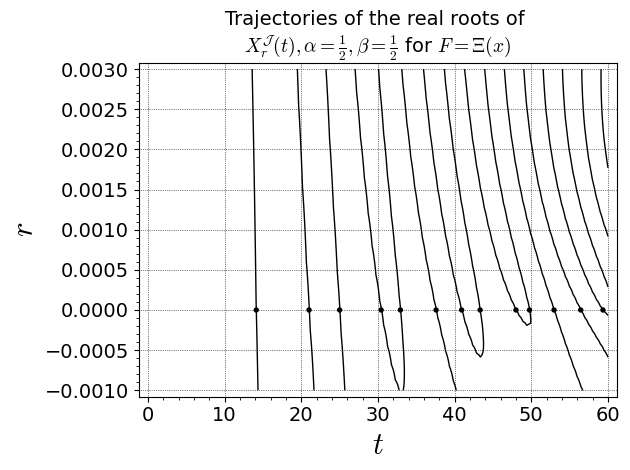

In [77]:
var("r","t");

#Generate a plot of all ordinates of the non-trivial zeros < 60 to overlay the flow graphs
var('y')
global ord, ordrho; ord = []; ordrho = []
with open("ordinateszetazeros.txt", "r") as f: #file is stored on GitHub
    for row in f:
        y=float(row)
        if y < 60:
            ord.append([y,0])
        ordrho.append(y)
z=list_plot(ord, size=15, marker="o", color = "black")

RDF=RealBallField(1024)
global m1; m1 = []; CoeffSum = 0
with open("JacobiCoeffa12b12", "r") as f:
    for row in f:
        CoeffSum= CoeffSum + RDF(row)
        m1.append([RDF(row)])
        
CCF=ComplexBallField(1024)
def Xi(t):
    f=CCF("0.5",0)+I*CCF(t)
    xi=f/2*(f-1)*CCF(pi).pow(-f/2)*(f/2).gamma()*f.zeta()
    return xi

def hyp(t,a,b,n):
    g=(1-t)/2
    f=CCF(g)
    hyp=f.hypergeometric([-n,n+a+b+1],[a+1])
    return hyp

def JacobiFlow(t,r):
    sum=CCF(0)
    for n in range(351):
        h = n+CCF("0.5")+CCF("0.5")+1
        r1 = CCF(-r,0).exp()
        g = r1.pow(h)
        sum=sum+g.pow(n)*CCF(str(m1[n]))*hyp(t,CCF("0.5"),CCF("0.5"),n)
    return real_part(sum);

#compute d/dr zk Newton approximation
def dzdrzk(k):
    tr = RDF("0.0000000001");x0 = RDF(ordrho[k-1]);
    while(y):
        hd = (JacobiFlow(x0 + tr*100,tr) - JacobiFlow(x0,tr))/(tr*100)
        h = JacobiFlow(x0,tr)/hd ;x1 = x0 - h;ab = h.abs();x0 = x1
        if ab < tr:
            break
    dzdr3 = (x1 - RDF(ordrho[k-1]))/(tr) 
    return dzdr3

#sum zeros around k-th zero
def sumzeros(k):
    zk =ordrho[k-1]
    sum0 = 0
    for j in range(k-1):
        sum0 = sum0 + 1/(zk-ordrho[j])
    sum1 = 0
    for j in range(k+1,300001):
        sum1 = sum1 + 1/(zk-ordrho[j-1])
    sum2 = 0
    for j in range(300000):
        sum2 = sum2 + 1/(zk+ordrho[j])
    return sum0 + sum1 + sum2

#compute d/dr zk via formula
def verifyPDE(k):
    return -2*(1-ordrho[k-1]^2)*sumzeros(k) - (-(0.5+0.5+2))*ordrho[k-1]

print("Automated checks:")
print("The sum of all the coefficients is   : %3.16f = Xi(1) = %3.16f (should be equal)." % (CoeffSum, JacobiFlow(1,0)))
print("d/dr z_1(0) via Newton approximation : %3.6f versus formula: %3.6f (should be close)." % (dzdrzk(3),verifyPDE(3)))
print("Ensure 20 digits accuracy at t = 60  : %3.20f (should show 20 zeros)." % real_part(JacobiFlow(60,0)-Xi(60)))

a1=implicit_plot(lambda t,r:((RDF(JacobiFlow(t,r)))),(t,0,60),(r,-0.001,0.003),color='black',fontsize=14,linestyle ="-",linewidth=1,axes_labels=['$t$','$r$'],title='Trajectories of the real roots of \n' +r'$X^{\mathcal{J}}_r(t), \alpha=\frac{1}{2}, \beta=\frac{1}{2}$ for $F=\Xi(x)$',gridlines=True,plot_points=120)
show(a1 + z,aspect_ratio='automatic')

Automated checks:
The sum of all the coefficients is   : 0.9588510772084060 = Xin(0) = 1.0000000000000000 (should be equal).
d/dr z_3(0) via Newton approximation : 18.955659 versus formula: 18.955659 (should be equal).
Ensure 20 digits accuracy at t = 60  : -0.00000000000000000000 (should show 20 zeros).


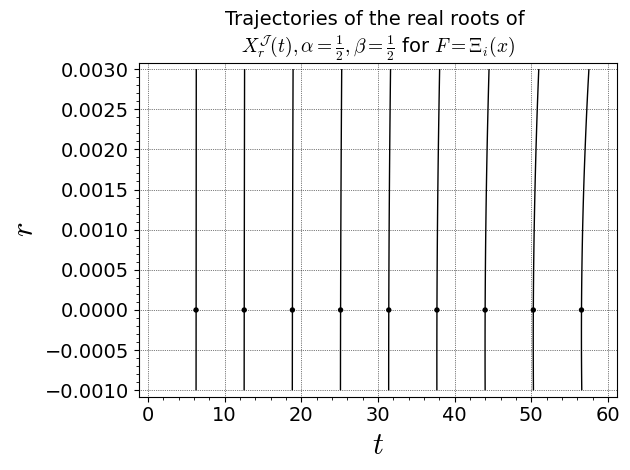

In [78]:
var("r","t");

#Generate a plot of all ordinates of the non-trivial zeros < 60 to overlay the flow graphs
var('y')
ord = []
for y in range(9):
    ord.append([2*pi()*(y+1),0])
z1=list_plot(ord, size=15, marker="o", color = "black")

RDF=RealBallField(1024)
global m1; m1 = []; CoeffSum = 0
with open("JacobiCoeffa12b12int", "r") as f:
    for row in f:
        CoeffSum= CoeffSum + RDF(row)
        m1.append([RDF(row)])
        
CCF=ComplexBallField(1024)
def Xin(t):
    Xin=2*CCF(t/2).sin()/CCF(t)
    return Xin

def hyp(t,a,b,n):
    f=CCF((1-t)/2)
    hyp=f.hypergeometric([-n,n+a+b+1],[a+1])
    return hyp

def JacobiFlow(t,r):
    sum=CCF(0)
    for n in range(301):
        h = n+CCF("0.5")+CCF("0.5")+1
        r1 = CCF(-r,0).exp()
        g = r1.pow(h)
        sum=sum+g.pow(n)*CCF(str(m1[n]))*hyp(t,CCF("0.5"),CCF("0.5"),n)
    return real_part(sum);

#compute d/dr zk Newton approximation
def dzdrzk(k):
    tr = RDF("0.000000000001");x0 = 2*k*RDF.pi();
    while(y):
        hd = (JacobiFlow(x0 + tr*100,tr) - JacobiFlow(x0,tr))/(tr*100)
        h = JacobiFlow(x0,tr)/hd ;x1 = x0 - h;ab = h.abs();x0 = x1
        if ab < tr:
            break
    dzdr3 = (x1 - 2*k*RDF.pi())/(tr) 
    return dzdr3

#compute d/dr zk via formula
def verifyPDE(k):
    return 2*(1-(2*k*pi())^2)/(2*k*pi()) - (-(0.5+0.5+2))*2*k*pi()

print("Automated checks:")
print("The sum of all the coefficients is   : %3.16f = Xin(0) = %3.16f (should be equal)." % (CoeffSum, JacobiFlow(0,0)))
print("d/dr z_3(0) via Newton approximation : %3.6f versus formula: %3.6f (should be equal)." % (dzdrzk(3),verifyPDE(3)))
print("Ensure 20 digits accuracy at t = 60  : %3.20f (should show 20 zeros)." % real_part(JacobiFlow(60,0)-Xin(60)))

a1i=implicit_plot(lambda t,r:((RDF(JacobiFlow(t,r)))),(t,0,60),(r,-0.001,0.003),color='black',linestyle ="-",fontsize=14,linewidth=1,axes_labels=['$t$','$r$'],title='Trajectories of the real roots of \n' +r'$X^{\mathcal{J}}_r(t), \alpha=\frac{1}{2}, \beta=\frac{1}{2}$ for $F=\Xi_i(x)$',gridlines=True,plot_points=120)
show(a1i + z1,aspect_ratio='automatic')